<a href="https://colab.research.google.com/github/uttkarsh-pr/mypython.py/blob/main/Air_Quality_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import pickle

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')  # for final submission
print(df_train.head())
print(df_train.info())

   No  DEWP  TEMP    PRES cbwd   Iws  Is  Ir  AQI
0   1   -16  -4.0  1020.0   SE  1.79   0   0  129
1   2   -15  -4.0  1020.0   SE  2.68   0   0  148
2   3   -11  -5.0  1021.0   SE  3.57   0   0  159
3   4    -7  -5.0  1022.0   SE  5.36   1   0  181
4   5    -7  -5.0  1022.0   SE  6.25   2   0  138
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41757 entries, 0 to 41756
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      41757 non-null  int64  
 1   DEWP    41757 non-null  int64  
 2   TEMP    41757 non-null  float64
 3   PRES    41757 non-null  float64
 4   cbwd    41757 non-null  object 
 5   Iws     41757 non-null  float64
 6   Is      41757 non-null  int64  
 7   Ir      41757 non-null  int64  
 8   AQI     41757 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 2.9+ MB
None


In [3]:
print("Missing values:\n", df_train.isnull().sum()[df_train.isnull().sum() > 0])

# Fill numerical nulls
for col in df_train.select_dtypes(include=['float64', 'int64']).columns:
    df_train[col].fillna(df_train[col].median(), inplace=True)

# Fill categorical nulls if present
for col in df_train.select_dtypes(include=['object']).columns:
    df_train[col].fillna(df_train[col].mode()[0], inplace=True)

print("Remaining nulls:", df_train.isnull().sum().max())

Missing values:
 Series([], dtype: int64)
Remaining nulls: 0


/tmp/ipython-input-3-2260285208.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_train[col].fillna(df_train[col].median(), inplace=True)
/tmp/ipython-input-3-2260285208.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

In [5]:
if 'datetime' in df_train.columns:
    df_train['datetime'] = pd.to_datetime(df_train['datetime'])
    df_train['year'] = df_train['datetime'].dt.year
    df_train['month'] = df_train['datetime'].dt.month
    df_train['day'] = df_train['datetime'].dt.day
    df_train['hour'] = df_train['datetime'].dt.hour
    df_train.drop('datetime', axis=1, inplace=True)

# Add interaction features
if 'lat' in df_train.columns and 'lon' in df_train.columns:
    df_train['lat_lon'] = df_train['lat'] * df_train['lon']
if 'hour' in df_train.columns:
    df_train['is_daytime'] = df_train['hour'].apply(lambda x: 1 if 6 <= x <= 18 else 0)

print("Features now include:", df_train.columns.tolist())

Features now include: ['No', 'DEWP', 'TEMP', 'PRES', 'cbwd', 'Iws', 'Is', 'Ir', 'AQI']


In [6]:
target = 'AQI'  # adjust if the actual target column has a different name
X = df_train.drop(columns=[target])  # remove identifier columns if present
y = df_train[target]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [9]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [10]:
print(X_train.dtypes)

No        int64
DEWP      int64
TEMP    float64
PRES    float64
cbwd     object
Iws     float64
Is        int64
Ir        int64
dtype: object


In [12]:
print(X_train.shape, X_val.shape)

(33405, 8) (8352, 8)


In [19]:
print("Object columns in X_train:")
print(X_train.select_dtypes(include=['object']).columns.tolist())

Object columns in X_train:
[]


In [21]:
X_train = pd.get_dummies(X_train, columns=['cbwd'])
X_val = pd.get_dummies(X_val, columns=['cbwd'])

# Align columns to ensure both datasets have the same features
X_train, X_val = X_train.align(X_val, join='left', axis=1, fill_value=0)


In [22]:
print(X_train.dtypes)

No          int64
DEWP        int64
TEMP      float64
PRES      float64
Iws       float64
Is          int64
Ir          int64
cbwd_0       bool
cbwd_1       bool
cbwd_2       bool
cbwd_3       bool
dtype: object


In [23]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [24]:
y_pred = model.predict(X_val)

print("R² Score:", r2_score(y_val, y_pred))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MSE:", mean_squared_error(y_val, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))

R² Score: 0.8155731191407574
MAE: 24.623630268199232
MSE: 1625.0802290229883
RMSE: 40.312283847767645


In [25]:
y_pred = model.predict(X_val)

print("R² Score:", r2_score(y_val, y_pred))
print("MAE:", mean_absolute_error(y_val, y_pred))
print("MSE:", mean_squared_error(y_val, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_pred)))

R² Score: 0.8155731191407574
MAE: 24.623630268199232
MSE: 1625.0802290229883
RMSE: 40.312283847767645


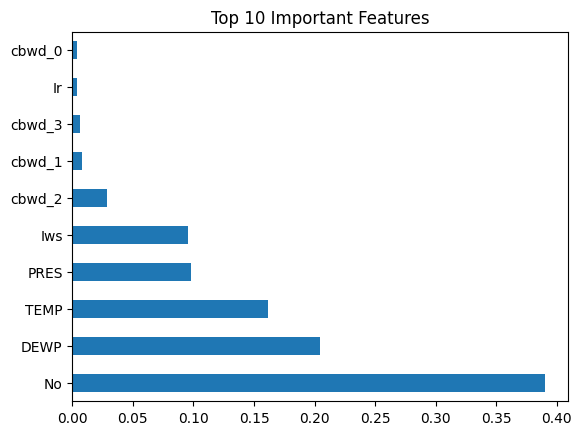

In [27]:
feat_imp = pd.Series(model.feature_importances_, index=X_train.columns)
feat_imp.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()

In [28]:
with open('air_quality_model.pkl', 'wb') as f:
    pickle.dump(model, f)
print("Model saved!")

Model saved!


In [29]:
import gradio as gr
import pickle
import numpy as np

# Load saved model
model = pickle.load(open('air_quality_model.pkl', 'rb'))

# Prediction function
def predict_air_quality(No, DEWP, TEMP, PRES, cbwd, Iws, Is, Ir):
    # Encode cbwd manually (example mapping)
    cbwd_mapping = {'NW':0, 'NE':1, 'SE':2, 'SW':3, 'cv':4}
    cbwd_encoded = cbwd_mapping.get(cbwd, -1)

    # Arrange features in order as per training data
    input_data = np.array([[No, DEWP, TEMP, PRES, cbwd_encoded, Iws, Is, Ir]])

    prediction = model.predict(input_data)
    return float(prediction[0])

# Gradio Interface
demo = gr.Interface(
    fn=predict_air_quality,
    inputs=[
        gr.Number(label="No"),
        gr.Number(label="DEWP"),
        gr.Number(label="TEMP"),
        gr.Number(label="PRES"),
        gr.Dropdown(choices=['NW','NE','SE','SW','cv'], label="cbwd"),
        gr.Number(label="Iws"),
        gr.Number(label="Is"),
        gr.Number(label="Ir")
    ],
    outputs=gr.Number(label="Predicted AQI"),
    title="🌬️ Air Quality Prediction Demo",
    description="Enter sensor and weather data to predict AQI using the trained Random Forest model."
)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b795f61a79209fd2d0.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
